Counting pixels in training dataset...


100%|██████████| 312/312 [00:03<00:00, 92.30it/s]


Training set pixel counts per class: [246824 929402 511532 265564  26869   1222     78    688  71243  11339
 317287  39283   2943   5882   3263  60444  99049   9014   5238 152943
  25991   2795  20328   1286   7426   8048   2480    830  46101      0]


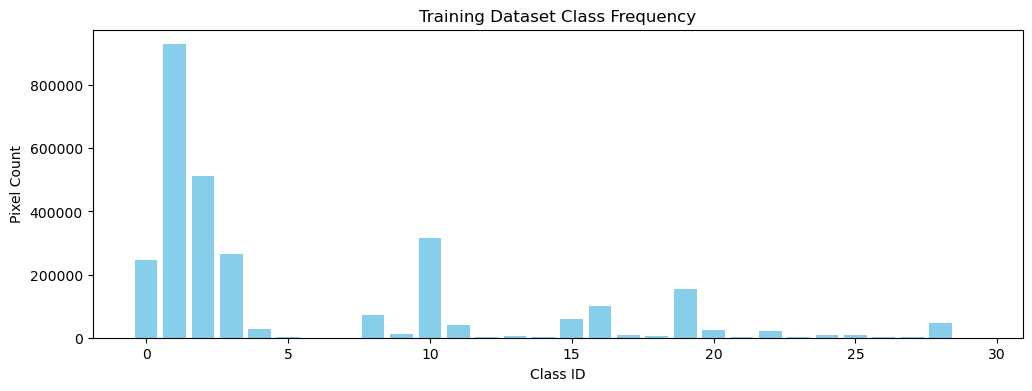

In [16]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append('/home/mrudul/mrudul/code_UAV_HSI')
# Dataset class unchanged
class HSIDataset(Dataset):
    def __init__(self, base_dir, split, transform=None):
        self.transform = transform
        self.image_dir = os.path.join(base_dir, split, 'rs')
        self.label_dir = os.path.join(base_dir, split, 'gt')
        self.sample_list = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.npy')]

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        name = self.sample_list[idx]
        img = np.load(os.path.join(self.image_dir, name + '.npy')).astype(np.float32)
        lbl = np.load(os.path.join(self.label_dir, name + '.npy')).astype(np.int64)
        img = img.transpose(2, 0, 1)
        for c in range(img.shape[0]):
            mn, mx = img[c].min(), img[c].max()
            if mx > mn:
                img[c] = (img[c] - mn) / (mx - mn)
        img_tensor = torch.from_numpy(img)
        lbl_tensor = torch.from_numpy(lbl)
        return {"image": img_tensor, "label": lbl_tensor}

# Paths for datasets
base_dir = '/home/mrudul/mrudul/data_UAV_HSI'
train_split = "Train/Training"
val_split = "Train/Validation"
test_split = "Test"  # example, add path if you have test set

# Instantiate datasets separately
train_ds = HSIDataset(base_dir, split=train_split)
val_ds = HSIDataset(base_dir, split=val_split)
# You can similarly instantiate test_ds if needed


# DataLoaders separately, no concatenation
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
# test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)  # if available

# Compute class pixel counts only on training dataset for class weights
num_classes = 30
pixel_counts = np.zeros(num_classes, dtype=np.int64)
print("Counting pixels in training dataset...")
for sample in tqdm(train_ds):
    lbl = sample["label"].numpy().ravel()
    counts = np.bincount(lbl, minlength=num_classes)
    pixel_counts += counts

print("Training set pixel counts per class:", pixel_counts)

# Visualization code if needed — only on training set
classes = np.arange(num_classes)
plt.figure(figsize=(12,4))
plt.bar(classes, pixel_counts, color='skyblue')
plt.xlabel("Class ID")
plt.ylabel("Pixel Count")
plt.title("Training Dataset Class Frequency")
plt.show()

# You can proceed from here with class weights, model, training loop, etc.


Counting pixels in train: 100%|██████████| 312/312 [00:03<00:00, 100.01it/s]


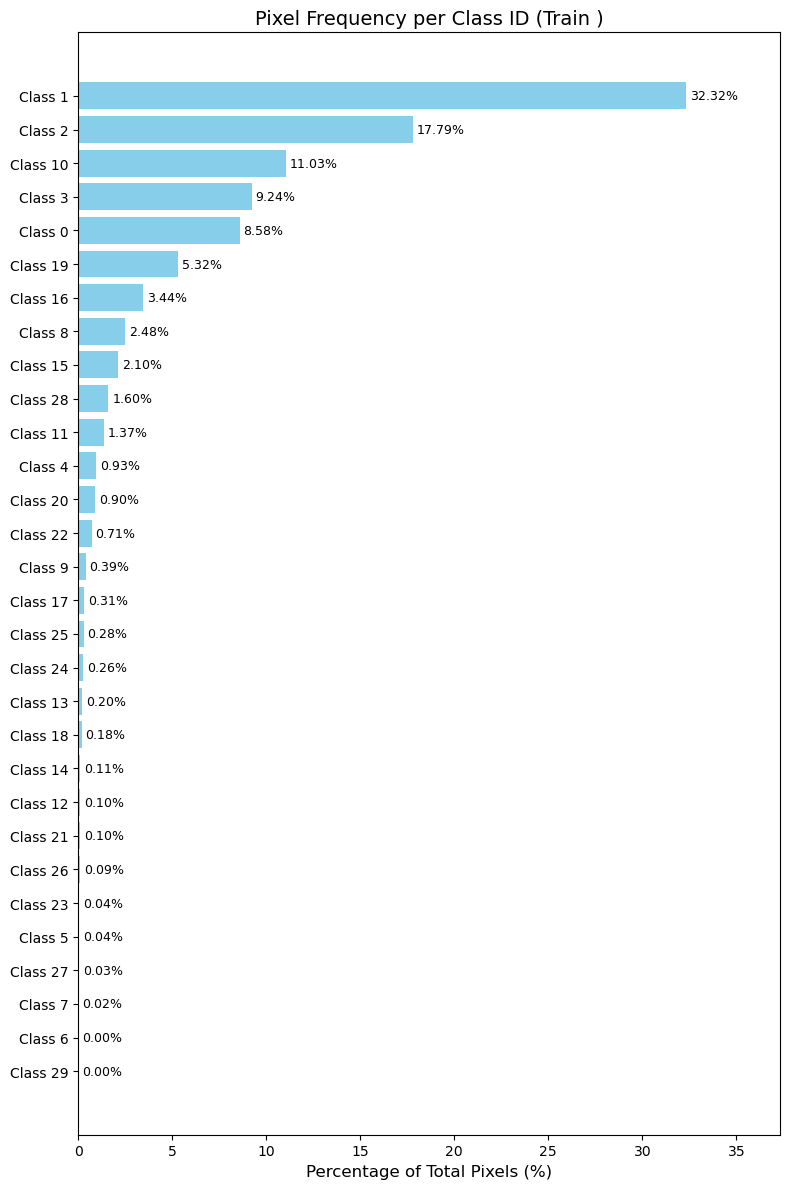

In [17]:
# 4. Combined Train+Validation Class Frequency Plot

num_classes = 30
pixel_counts = np.zeros(num_classes, dtype=np.int64)
for sample in tqdm(train_ds, desc="Counting pixels in train"):
    lbl = sample["label"].numpy().ravel()
    counts = np.bincount(lbl, minlength=num_classes)
    pixel_counts += counts

# Compute percentages
percentages = pixel_counts / pixel_counts.sum() * 100

# Sort classes by descending frequency
order = np.argsort(percentages)[::-1]
sorted_ids  = order
sorted_perc = percentages[order]

# Plot horizontal bar chart
plt.figure(figsize=(8, 12))
y = np.arange(num_classes)
bars = plt.barh(y, sorted_perc, color='skyblue')
plt.yticks(y, [f"Class {i}" for i in sorted_ids], fontsize=10)
plt.xlabel("Percentage of Total Pixels (%)", fontsize=12)
plt.title("Pixel Frequency per Class ID (Train )", fontsize=14)
plt.gca().invert_yaxis()

# Annotate percentages
for bar, pct in zip(bars, sorted_perc):
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2,
             f"{pct:.2f}%", va='center', fontsize=9)

plt.xlim(0, sorted_perc.max() + 5)
plt.tight_layout()
plt.show()


Counting pixels in test dataset...


100%|██████████| 87/87 [00:00<00:00, 99.86it/s] 


Test set pixel counts per class: [ 89208 222468 127369  76787   5767   2313    766      0  12473  12854
  96149   2981   1762   3147   1618   7684  18378   1855   3096  59260
   4456      0  12743    734   1622   2596   1216      0  32187    303]


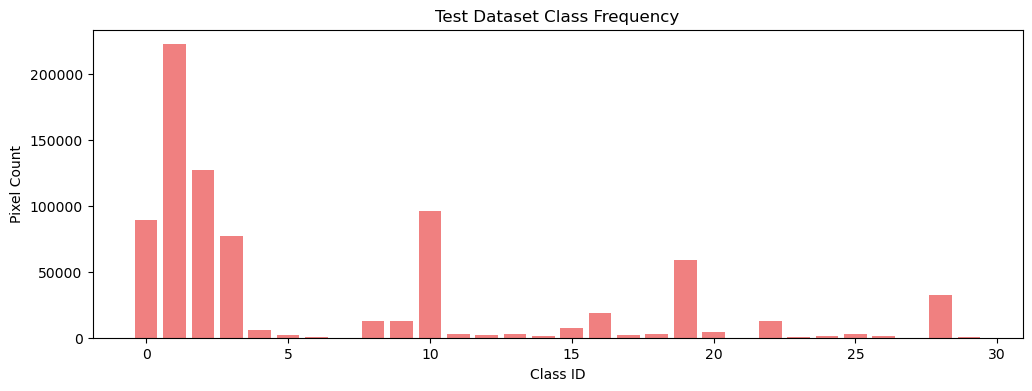

In [18]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Dataset class (same as your HSIDataset)
class HSIDataset(Dataset):
    def __init__(self, base_dir, split, transform=None):
        self.transform = transform
        self.image_dir = os.path.join(base_dir, split, 'rs')
        self.label_dir = os.path.join(base_dir, split, 'gt')
        self.sample_list = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.npy')]

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        name = self.sample_list[idx]
        img = np.load(os.path.join(self.image_dir, name + '.npy')).astype(np.float32)
        lbl = np.load(os.path.join(self.label_dir, name + '.npy')).astype(np.int64)
        # Transpose (H,W,D) to (D,H,W)
        img = img.transpose(2, 0, 1)
        for c in range(img.shape[0]):
            mn, mx = img[c].min(), img[c].max()
            if mx > mn:
                img[c] = (img[c] - mn) / (mx - mn)
        img_tensor = torch.from_numpy(img)
        lbl_tensor = torch.from_numpy(lbl)
        return {"image": img_tensor, "label": lbl_tensor}

# Paths and split
base_dir = '/home/mrudul/mrudul/data_UAV_HSI'
test_split = "Test"

# Instantiate test dataset and loader
test_ds = HSIDataset(base_dir, split=test_split)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

num_classes = 30
pixel_counts_test = np.zeros(num_classes, dtype=np.int64)

print("Counting pixels in test dataset...")
for sample in tqdm(test_ds):
    lbl = sample["label"].numpy().ravel()
    counts = np.bincount(lbl, minlength=num_classes)
    pixel_counts_test += counts

print("Test set pixel counts per class:", pixel_counts_test)

# Visualization for test set class frequency
classes = np.arange(num_classes)
plt.figure(figsize=(12,4))
plt.bar(classes, pixel_counts_test, color='lightcoral')
plt.xlabel("Class ID")
plt.ylabel("Pixel Count")
plt.title("Test Dataset Class Frequency")
plt.show()


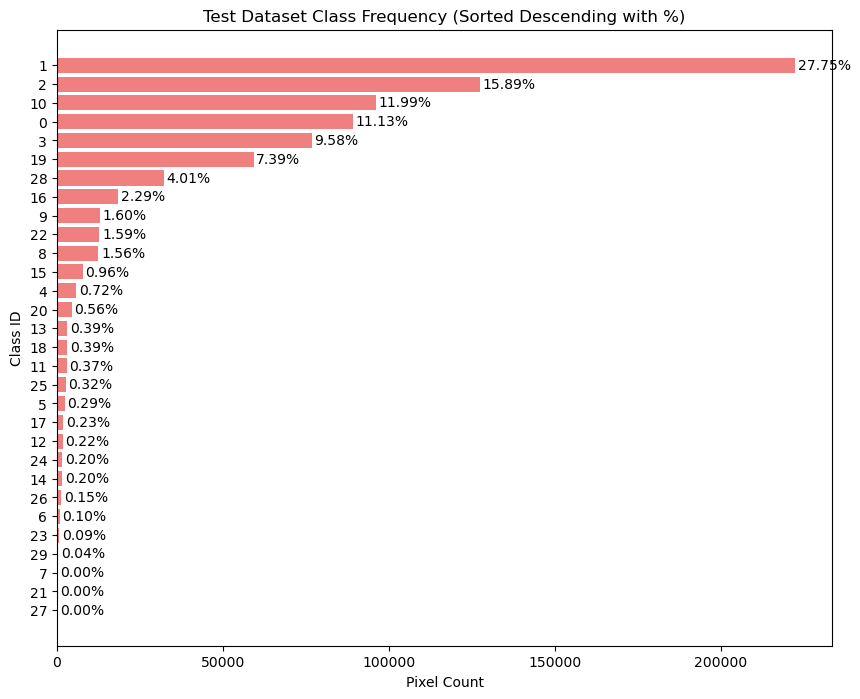

In [19]:
# Calculate total pixels for percentage calculation
total_pixels = pixel_counts_test.sum()

# Sort classes by pixel count descending
sorted_indices = np.argsort(pixel_counts_test)[::-1]
sorted_counts = pixel_counts_test[sorted_indices]
sorted_classes = np.arange(num_classes)[sorted_indices]

# Calculate percentages
sorted_percentages = (sorted_counts / total_pixels) * 100

plt.figure(figsize=(10, 8))
bars = plt.barh(sorted_classes.astype(str), sorted_counts, color='lightcoral')
plt.xlabel("Pixel Count")
plt.ylabel("Class ID")
plt.title("Test Dataset Class Frequency (Sorted Descending with %)")
plt.gca().invert_yaxis()  # Highest on top

# Add percentage labels to bars
for bar, percent in zip(bars, sorted_percentages):
    width = bar.get_width()
    plt.text(width + total_pixels*0.001, bar.get_y() + bar.get_height() / 2,
             f"{percent:.2f}%", va='center')

plt.show()


In [20]:
pixel_counts_test

array([ 89208, 222468, 127369,  76787,   5767,   2313,    766,      0,
        12473,  12854,  96149,   2981,   1762,   3147,   1618,   7684,
        18378,   1855,   3096,  59260,   4456,      0,  12743,    734,
         1622,   2596,   1216,      0,  32187,    303])

In [22]:

import torch
import torch.nn as nn
import sys
sys.path.append('/home/mrudul/mrudul/data_UAV_HSI/TransUNet-main/pytorch-3dunet-master')
from pytorch3dunet.unet3d.model import UNet3D

class EfficientSpectralAttentionUNet3D(nn.Module):
    def __init__(self, in_channels=1, out_classes=30, spectral_dim=30, reduction=16):  # spectral_dim=30 for PCA input
        super().__init__()
        self.unet3d = UNet3D(
            in_channels=in_channels,
            out_channels=out_classes,
            final_sigmoid=False,
            f_maps=64,
            layer_order='gcr',
            num_groups=1,
            num_levels=4,
            is_segmentation=True,
            conv_padding=1,
            conv_upscale=2,
            upsample='default',
            dropout_prob=0.1,
            is3d=True,
        )
        self.global_avg_pool = nn.AdaptiveAvgPool3d((spectral_dim, 1, 1))
        self.fc1 = nn.Linear(out_classes, out_classes // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(out_classes // reduction, out_classes, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):  # x shape: (B, 1, 30, 96, 96)
        out = self.unet3d(x)         # Expected out shape: (B, 30, 30, 96, 96)

        attn = self.global_avg_pool(out)   # (B, 30, 30, 1, 1)
        attn = attn.squeeze(-1).squeeze(-1).permute(0, 2, 1)  # (B, 30, 30)
        attn = self.fc1(attn)    # (B, 30, 30//reduction)
        attn = self.relu(attn)
        attn = self.fc2(attn)    # (B, 30, 30)
        attn = self.sigmoid(attn)
        attn = attn.permute(0, 2, 1).unsqueeze(-1).unsqueeze(-1)  # (B,30,30,1,1)
        out_attn = out * attn    # (B,30,30,96,96)
        fused = out_attn.sum(dim=2)  # (B,30,96,96)
        return fused

# Test run
model = EfficientSpectralAttentionUNet3D()
dummy_input = torch.randn(1, 1, 30, 96, 96)
output = model(dummy_input)
print("Output shape with efficient spectral attention fusion:", output.shape)  # Expected (1,30,96,96)


Output shape with efficient spectral attention fusion: torch.Size([1, 30, 96, 96])


PCA

In [8]:
import os
import numpy as np
from sklearn.decomposition import PCA
import joblib

base_dir = '/home/mrudul/mrudul/data_UAV_HSI'
train_split = "Train/Training"
train_image_dir = os.path.join(base_dir, train_split, 'rs')
sample_list = [f[:-4] for f in os.listdir(train_image_dir) if f.endswith('.npy')]

all_train_imgs = []
for name in sample_list:
    img = np.load(os.path.join(train_image_dir, name + '.npy')).astype(np.float32)  # (H, W, 200)
    h, w, c = img.shape
    img_flat = img.reshape(-1, c)  # (H*W, C)
    all_train_imgs.append(img_flat)
X_pca = np.concatenate(all_train_imgs, axis=0)  # (N * H * W, 200)

pca = PCA(n_components=30, whiten=False, random_state=2025)
pca.fit(X_pca)
joblib.dump(pca, 'hsi_pca_30bands.pkl')
print("PCA fitted and saved. Variance retained:", pca.explained_variance_ratio_.sum())


PCA fitted and saved. Variance retained: 0.9966520117446567


In [4]:
import torch
from torch.utils.data import Dataset
import joblib

class HSIDataset(Dataset):
    def __init__(self, base_dir, split, pca_path=None, transform=None):
        self.transform = transform
        self.image_dir = os.path.join(base_dir, split, 'rs')
        self.label_dir = os.path.join(base_dir, split, 'gt')
        self.sample_list = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.npy')]
        if pca_path is not None:
            self.pca = joblib.load(pca_path)
        else:
            self.pca = None

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        name = self.sample_list[idx]
        img = np.load(os.path.join(self.image_dir, name + '.npy')).astype(np.float32)  # (H, W, orig_C)
        lbl = np.load(os.path.join(self.label_dir, name + '.npy')).astype(np.int64)
        if self.pca is not None:
            h, w, c = img.shape
            img_flat = img.reshape(-1, c)                  # (H*W, orig_C)
            img_pca = self.pca.transform(img_flat)          # (H*W, 30)
            img = img_pca.reshape(h, w, 30)                 # (H, W, 30)
        img = img.transpose(2, 0, 1)                        # (30, H, W)
        for c in range(img.shape[0]):
            mn, mx = img[c].min(), img[c].max()
            if mx > mn:
                img[c] = (img[c] - mn) / (mx - mn)
        img_tensor = torch.from_numpy(img)
        lbl_tensor = torch.from_numpy(lbl)
        return {"image": img_tensor, "label": lbl_tensor}


Counting pixels in training dataset...


100%|██████████| 312/312 [00:02<00:00, 150.37it/s]


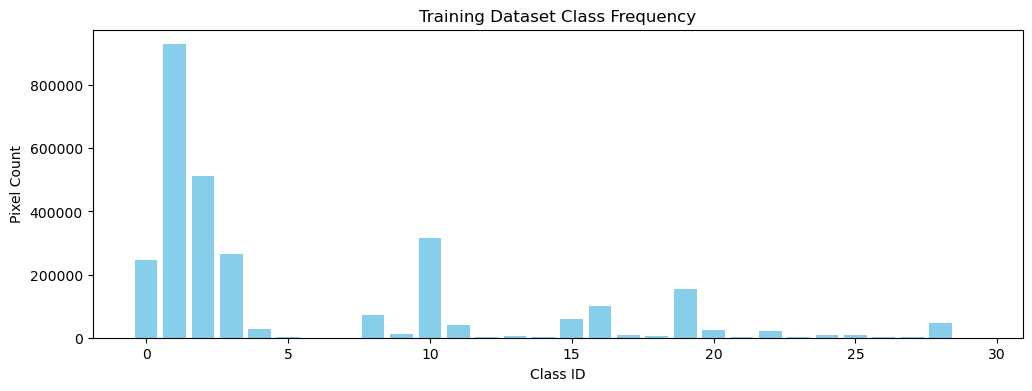

In [10]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

pca_path = 'hsi_pca_30bands.pkl'
train_ds = HSIDataset(base_dir, split=train_split, pca_path=pca_path)
val_split = "Train/Validation"
val_ds = HSIDataset(base_dir, split=val_split, pca_path=pca_path)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

num_classes = 30
pixel_counts = np.zeros(num_classes, dtype=np.int64)
print("Counting pixels in training dataset...")
for sample in tqdm(train_ds):
    lbl = sample["label"].numpy().ravel()
    counts = np.bincount(lbl, minlength=num_classes)
    pixel_counts += counts

plt.figure(figsize=(12,4))
plt.bar(np.arange(num_classes), pixel_counts, color='skyblue')
plt.xlabel("Class ID")
plt.ylabel("Pixel Count")
plt.title("Training Dataset Class Frequency")
plt.show()


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Dice
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientSpectralAttentionUNet3D(in_channels=1, out_classes=30, spectral_dim=30).to(device)
print(f"Using device: {device}")

num_classes = 30
criterion_ce = nn.CrossEntropyLoss()
criterion_dice = Dice(num_classes=num_classes, ignore_index=None, mdmc_average='samplewise').to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
scaler = GradScaler()
num_epochs = 50
best_val_loss = float('inf')
save_path = '3dunet_hsi_PCA.pt'

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_train_ce = 0.0
    running_train_dice = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1} Training", ncols=100)
    for batch in train_loader_tqdm:
        images = batch['image'].to(device).unsqueeze(1)
        labels = batch['label'].to(device).long()
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss_ce = criterion_ce(outputs, labels)
            loss_dice = 1 - criterion_dice(outputs.softmax(dim=1), labels)
            loss = 0.5 * (loss_ce + loss_dice)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_train_loss += loss.item() * images.size(0)
        running_train_ce += loss_ce.item() * images.size(0)
        running_train_dice += loss_dice.item() * images.size(0)

    train_loss = running_train_loss / len(train_loader.dataset)
    train_ce = running_train_ce / len(train_loader.dataset)
    train_dice = running_train_dice / len(train_loader.dataset)

    model.eval()
    running_val_loss = 0.0
    running_val_ce = 0.0
    running_val_dice = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", ncols=100):
            images = batch['image'].to(device).unsqueeze(1)
            labels = batch['label'].to(device).long()
            with autocast():
                outputs = model(images)
                loss_ce = criterion_ce(outputs, labels)
                loss_dice = 1 - criterion_dice(outputs.softmax(dim=1), labels)
                loss = 0.5 * (loss_ce + loss_dice)

            running_val_loss += loss.item() * images.size(0)
            running_val_ce += loss_ce.item() * images.size(0)
            running_val_dice += loss_dice.item() * images.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    val_ce = running_val_ce / len(val_loader.dataset)
    val_dice = running_val_dice / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {train_loss:.4f} CE: {train_ce:.4f} Dice: {train_dice:.4f} | "
          f"Val Loss: {val_loss:.4f} CE: {val_ce:.4f} Dice: {val_dice:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model at epoch {epoch+1} with validation loss {best_val_loss:.4f}")


Using device: cuda


Epoch 1 Validation: 100%|███████████████████████████████████████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 1/50 Train Loss: 1.5140 CE: 2.3934 Dice: 0.6346 | Val Loss: 1.3739 CE: 2.1924 Dice: 0.5553
Saved best model at epoch 1 with validation loss 1.3739


Epoch 2 Validation: 100%|███████████████████████████████████████████| 34/34 [00:10<00:00,  3.10it/s]


Epoch 2/50 Train Loss: 1.2330 CE: 1.9445 Dice: 0.5214 | Val Loss: 1.2303 CE: 1.9381 Dice: 0.5224
Saved best model at epoch 2 with validation loss 1.2303


Epoch 3 Validation: 100%|███████████████████████████████████████████| 34/34 [00:10<00:00,  3.11it/s]


Epoch 3/50 Train Loss: 1.2267 CE: 1.9275 Dice: 0.5259 | Val Loss: 1.3462 CE: 2.0844 Dice: 0.6081


Epoch 4 Validation: 100%|███████████████████████████████████████████| 34/34 [00:10<00:00,  3.11it/s]


Epoch 4/50 Train Loss: 1.1738 CE: 1.8562 Dice: 0.4914 | Val Loss: 1.2834 CE: 2.0065 Dice: 0.5603


Epoch 5 Validation: 100%|███████████████████████████████████████████| 34/34 [00:10<00:00,  3.11it/s]


Epoch 5/50 Train Loss: 1.1151 CE: 1.7558 Dice: 0.4744 | Val Loss: 1.2527 CE: 1.9256 Dice: 0.5799


Epoch 6 Validation: 100%|███████████████████████████████████████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 6/50 Train Loss: 1.0423 CE: 1.6415 Dice: 0.4431 | Val Loss: 1.1775 CE: 1.8581 Dice: 0.4969
Saved best model at epoch 6 with validation loss 1.1775


Epoch 7 Validation: 100%|███████████████████████████████████████████| 34/34 [00:10<00:00,  3.11it/s]


Epoch 7/50 Train Loss: 1.0035 CE: 1.5871 Dice: 0.4198 | Val Loss: 1.0657 CE: 1.6595 Dice: 0.4720
Saved best model at epoch 7 with validation loss 1.0657


Epoch 8 Validation: 100%|███████████████████████████████████████████| 34/34 [00:10<00:00,  3.11it/s]


Epoch 8/50 Train Loss: 0.9645 CE: 1.5274 Dice: 0.4015 | Val Loss: 1.1237 CE: 1.7654 Dice: 0.4820


Epoch 9 Validation: 100%|███████████████████████████████████████████| 34/34 [00:10<00:00,  3.11it/s]


Epoch 9/50 Train Loss: 0.9254 CE: 1.4742 Dice: 0.3766 | Val Loss: 1.0484 CE: 1.6671 Dice: 0.4296
Saved best model at epoch 9 with validation loss 1.0484


Epoch 10 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 10/50 Train Loss: 0.9077 CE: 1.4434 Dice: 0.3720 | Val Loss: 1.0157 CE: 1.5910 Dice: 0.4404
Saved best model at epoch 10 with validation loss 1.0157


Epoch 11 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.10it/s]


Epoch 11/50 Train Loss: 0.8811 CE: 1.4039 Dice: 0.3584 | Val Loss: 1.0055 CE: 1.5919 Dice: 0.4191
Saved best model at epoch 11 with validation loss 1.0055


Epoch 12 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 12/50 Train Loss: 0.8215 CE: 1.3091 Dice: 0.3339 | Val Loss: 0.9332 CE: 1.4497 Dice: 0.4167
Saved best model at epoch 12 with validation loss 0.9332


Epoch 13 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 13/50 Train Loss: 0.7926 CE: 1.2630 Dice: 0.3221 | Val Loss: 0.9195 CE: 1.4190 Dice: 0.4201
Saved best model at epoch 13 with validation loss 0.9195


Epoch 14 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.10it/s]


Epoch 14/50 Train Loss: 0.7571 CE: 1.1995 Dice: 0.3148 | Val Loss: 0.9701 CE: 1.5245 Dice: 0.4157


Epoch 15 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 15/50 Train Loss: 0.7248 CE: 1.1539 Dice: 0.2957 | Val Loss: 0.9722 CE: 1.5393 Dice: 0.4051


Epoch 16 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 16/50 Train Loss: 0.7148 CE: 1.1349 Dice: 0.2948 | Val Loss: 0.8765 CE: 1.3712 Dice: 0.3817
Saved best model at epoch 16 with validation loss 0.8765


Epoch 17 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 17/50 Train Loss: 0.6769 CE: 1.0752 Dice: 0.2785 | Val Loss: 0.8106 CE: 1.2652 Dice: 0.3561
Saved best model at epoch 17 with validation loss 0.8106


Epoch 18 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 18/50 Train Loss: 0.6607 CE: 1.0478 Dice: 0.2735 | Val Loss: 0.8085 CE: 1.2824 Dice: 0.3345
Saved best model at epoch 18 with validation loss 0.8085


Epoch 19 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 19/50 Train Loss: 0.6281 CE: 1.0007 Dice: 0.2555 | Val Loss: 0.8294 CE: 1.3141 Dice: 0.3447


Epoch 20 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 20/50 Train Loss: 0.6229 CE: 0.9913 Dice: 0.2546 | Val Loss: 0.8194 CE: 1.2651 Dice: 0.3737


Epoch 21 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 21/50 Train Loss: 0.6301 CE: 1.0059 Dice: 0.2542 | Val Loss: 0.8680 CE: 1.3796 Dice: 0.3564


Epoch 22 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 22/50 Train Loss: 0.5859 CE: 0.9347 Dice: 0.2371 | Val Loss: 0.7025 CE: 1.1130 Dice: 0.2921
Saved best model at epoch 22 with validation loss 0.7025


Epoch 23 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 23/50 Train Loss: 0.5755 CE: 0.9170 Dice: 0.2341 | Val Loss: 0.8538 CE: 1.3663 Dice: 0.3413


Epoch 24 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 24/50 Train Loss: 0.5510 CE: 0.8768 Dice: 0.2251 | Val Loss: 0.7784 CE: 1.2175 Dice: 0.3394


Epoch 25 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 25/50 Train Loss: 0.5657 CE: 0.8981 Dice: 0.2334 | Val Loss: 0.8080 CE: 1.2906 Dice: 0.3255


Epoch 26 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 26/50 Train Loss: 0.5127 CE: 0.8187 Dice: 0.2067 | Val Loss: 0.7575 CE: 1.1885 Dice: 0.3266


Epoch 27 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.15it/s]


Epoch 27/50 Train Loss: 0.5372 CE: 0.8565 Dice: 0.2179 | Val Loss: 0.8029 CE: 1.2669 Dice: 0.3388


Epoch 28 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 28/50 Train Loss: 0.5017 CE: 0.7971 Dice: 0.2064 | Val Loss: 0.7648 CE: 1.2074 Dice: 0.3222


Epoch 29 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 29/50 Train Loss: 0.4816 CE: 0.7686 Dice: 0.1946 | Val Loss: 0.7725 CE: 1.2299 Dice: 0.3150


Epoch 30 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 30/50 Train Loss: 0.4845 CE: 0.7693 Dice: 0.1998 | Val Loss: 0.7821 CE: 1.2167 Dice: 0.3474


Epoch 31 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 31/50 Train Loss: 0.5260 CE: 0.8370 Dice: 0.2151 | Val Loss: 0.7282 CE: 1.1410 Dice: 0.3154


Epoch 32 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 32/50 Train Loss: 0.4723 CE: 0.7497 Dice: 0.1950 | Val Loss: 0.7370 CE: 1.1706 Dice: 0.3035


Epoch 33 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 33/50 Train Loss: 0.4338 CE: 0.6905 Dice: 0.1770 | Val Loss: 0.6824 CE: 1.0918 Dice: 0.2730
Saved best model at epoch 33 with validation loss 0.6824


Epoch 34 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 34/50 Train Loss: 0.4290 CE: 0.6801 Dice: 0.1779 | Val Loss: 0.7524 CE: 1.1831 Dice: 0.3217


Epoch 35 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.15it/s]


Epoch 35/50 Train Loss: 0.4488 CE: 0.7123 Dice: 0.1853 | Val Loss: 0.7205 CE: 1.1353 Dice: 0.3056


Epoch 36 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 36/50 Train Loss: 0.4173 CE: 0.6628 Dice: 0.1718 | Val Loss: 0.7414 CE: 1.1652 Dice: 0.3176


Epoch 37 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 37/50 Train Loss: 0.4105 CE: 0.6517 Dice: 0.1692 | Val Loss: 0.7447 CE: 1.1863 Dice: 0.3031


Epoch 38 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 38/50 Train Loss: 0.3878 CE: 0.6175 Dice: 0.1580 | Val Loss: 0.7639 CE: 1.2200 Dice: 0.3078


Epoch 39 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 39/50 Train Loss: 0.3656 CE: 0.5797 Dice: 0.1515 | Val Loss: 0.7770 CE: 1.2114 Dice: 0.3425


Epoch 40 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 40/50 Train Loss: 0.3806 CE: 0.6041 Dice: 0.1572 | Val Loss: 0.7887 CE: 1.2520 Dice: 0.3254


Epoch 41 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 41/50 Train Loss: 0.4227 CE: 0.6701 Dice: 0.1754 | Val Loss: 0.7042 CE: 1.1199 Dice: 0.2885


Epoch 42 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 42/50 Train Loss: 0.3559 CE: 0.5666 Dice: 0.1451 | Val Loss: 0.7625 CE: 1.2176 Dice: 0.3074


Epoch 43 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 43/50 Train Loss: 0.3381 CE: 0.5369 Dice: 0.1393 | Val Loss: 0.7278 CE: 1.1528 Dice: 0.3027


Epoch 44 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 44/50 Train Loss: 0.3330 CE: 0.5259 Dice: 0.1401 | Val Loss: 0.9015 CE: 1.4701 Dice: 0.3330


Epoch 45 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 45/50 Train Loss: 0.3250 CE: 0.5137 Dice: 0.1363 | Val Loss: 0.9340 CE: 1.5283 Dice: 0.3398


Epoch 46 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]


Epoch 46/50 Train Loss: 0.3077 CE: 0.4880 Dice: 0.1274 | Val Loss: 0.6483 CE: 1.0278 Dice: 0.2689
Saved best model at epoch 46 with validation loss 0.6483


Epoch 47 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 47/50 Train Loss: 0.3174 CE: 0.5034 Dice: 0.1314 | Val Loss: 0.8898 CE: 1.4615 Dice: 0.3181


Epoch 48 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 48/50 Train Loss: 0.3017 CE: 0.4804 Dice: 0.1230 | Val Loss: 0.7935 CE: 1.2552 Dice: 0.3318


Epoch 49 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 49/50 Train Loss: 0.3204 CE: 0.5065 Dice: 0.1342 | Val Loss: 0.8754 CE: 1.4089 Dice: 0.3420


Epoch 50 Validation: 100%|██████████████████████████████████████████| 34/34 [00:10<00:00,  3.13it/s]

Epoch 50/50 Train Loss: 0.3069 CE: 0.4871 Dice: 0.1266 | Val Loss: 0.7593 CE: 1.2273 Dice: 0.2913


In [24]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import joblib

class HSIDataset(Dataset):
    def __init__(self, base_dir, split, pca_path=None):
        self.image_dir = os.path.join(base_dir, split, 'rs')
        self.label_dir = os.path.join(base_dir, split, 'gt')
        self.sample_list = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.npy')]
        self.pca = joblib.load(pca_path) if pca_path else None

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        name = self.sample_list[idx]
        img = np.load(os.path.join(self.image_dir, name + '.npy')).astype(np.float32)
        lbl = np.load(os.path.join(self.label_dir, name + '.npy')).astype(np.int64)
        if self.pca is not None:
            h, w, c = img.shape
            img_flat = img.reshape(-1, c)
            img_pca = self.pca.transform(img_flat)
            img = img_pca.reshape(h, w, 30)
        img = img.transpose(2, 0, 1)  # (30, H, W)
        for c in range(img.shape[0]):
            mn, mx = img[c].min(), img[c].max()
            if mx > mn:
                img[c] = (img[c] - mn) / (mx - mn)
        img_tensor = torch.from_numpy(img)
        lbl_tensor = torch.from_numpy(lbl)
        return {"image": img_tensor, "label": lbl_tensor}

base_dir = '/home/mrudul/mrudul/data_UAV_HSI'
test_split = 'Test'
pca_path = 'hsi_pca_30bands.pkl'
test_ds = HSIDataset(base_dir, split=test_split, pca_path=pca_path)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


num_classes = 30
model = EfficientSpectralAttentionUNet3D(in_channels=1, out_classes=num_classes, spectral_dim=30).to(device)
model.load_state_dict(torch.load('3dunet_hsi_PCA.pt', map_location=device))
model.eval()

from torchmetrics import Dice, JaccardIndex, ConfusionMatrix
from sklearn.metrics import cohen_kappa_score, accuracy_score
import numpy as np
from tqdm import tqdm

dice_metric = Dice(num_classes=num_classes, average=None).to(device)
iou_metric = JaccardIndex(num_classes=num_classes, average=None, task='multiclass').to(device)
confmat_metric = ConfusionMatrix(num_classes=num_classes).to(device)

all_preds = []
all_gts = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        images = batch['image'].to(device).unsqueeze(1)
        labels = batch['label'].to(device).long()
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        dice_metric.update(preds, labels)
        iou_metric.update(preds, labels)
        confmat_metric.update(preds, labels)
        all_preds.append(preds.cpu().numpy().flatten())
        all_gts.append(labels.cpu().numpy().flatten())

dice_per_class = dice_metric.compute().cpu().numpy()
iou_per_class = iou_metric.compute().cpu().numpy()
conf_matrix = confmat_metric.compute().cpu().numpy()

# Flatten all predictions and true labels for OA and Kappa
all_preds_flat = np.concatenate(all_preds)
all_gts_flat = np.concatenate(all_gts)

OA = accuracy_score(all_gts_flat, all_preds_flat)
per_class_oa = np.diag(conf_matrix) / conf_matrix.sum(axis=1)
kappa = cohen_kappa_score(all_gts_flat, all_preds_flat)

print("Per-class Dice:", dice_per_class)
print("Per-class IOU:", iou_per_class)
print("Confusion matrix:\n", conf_matrix)
print(f"Overall Accuracy (OA): {OA:.4f}")
print("Per-class OA:", per_class_oa)
print(f"Cohen's Kappa: {kappa:.4f}")


Testing: 100%|██████████| 87/87 [00:26<00:00,  3.23it/s]
/home/mrudul/miniconda3/envs/hsi_transunet/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide


Per-class Dice: [0.99083954 0.8305107  0.8977415  0.8442103  0.13436313 0.
 0.                nan 0.28997174 0.         0.8263022  0.31389025
 0.         0.         0.         0.5286227  0.31672585 0.
 0.         0.58017534 0.31605202        nan 0.68111485 0.
 0.         0.         0.                nan 0.35767472 0.        ]
Per-class IOU: [0.9818454  0.71014816 0.81445646 0.7304186  0.07201998 0.
 0.         0.         0.16957131 0.         0.7040161  0.18616241
 0.         0.         0.         0.35927063 0.18816058 0.
 0.         0.40862465 0.18768515 0.         0.5164323  0.
 0.         0.         0.         0.         0.21778555 0.        ]
Confusion matrix:
 [[ 87938    444      0      1      0      0      0      0      0      0
     277      0      0      0      0      0      0      0      0     83
       4      0      0      0      0      0      0      0    461      0]
 [   144 195932   2928    462     86      0      0      0      0      0
    1615      0      0      0      0 

Visualize

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sklearn.metrics import confusion_matrix

# Assume you have a dict or list of class names (adjust as per your dataset)
class_names = [f"Class {i}" for i in range(num_classes)]  # Replace with actual class names if available

# Define a categorical colormap for visualizing segmentation masks
cmap = plt.get_cmap('tab20', num_classes) 

def visualize_prediction(image, gt_mask, pred_mask, class_names, idx=0):
    """
    image: np.array (C, H, W), normalized float
    gt_mask: np.array (H, W) ground truth labels
    pred_mask: np.array (H, W) predicted labels
    """
    plt.figure(figsize=(15,5))
    
    # Show image as RGB if C=3 else grayscale, else first 3 bands normalized for visualization
    if image.shape[0] == 3:
        img_disp = np.transpose(image, (1,2,0))
    else:
        img_disp = np.mean(image[:3], axis=0)  # mean of first 3 bands
    img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min() + 1e-8)
    
    plt.subplot(1,3,1)
    plt.title("Input Image")
    plt.imshow(img_disp, cmap='gray' if img_disp.ndim==2 else None)
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    im1 = plt.imshow(gt_mask, cmap=cmap, vmin=0, vmax=num_classes-1)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Prediction")
    im2 = plt.imshow(pred_mask, cmap=cmap, vmin=0, vmax=num_classes-1)
    plt.axis('off')
    
    # Color legends for classes
    # Put legend outside on right
    handles = [plt.Rectangle((0,0),1,1, color=cmap(i)) for i in range(num_classes)]
    plt.legend(handles, class_names, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    plt.suptitle(f"Sample {idx}")
    plt.tight_layout()
    plt.show()

def plot_confusion_heatmap(conf_matrix, class_names):
    plt.figure(figsize=(12,10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix Heatmap')
    plt.show()


Visualizing sample #56 with Dice=0.1503


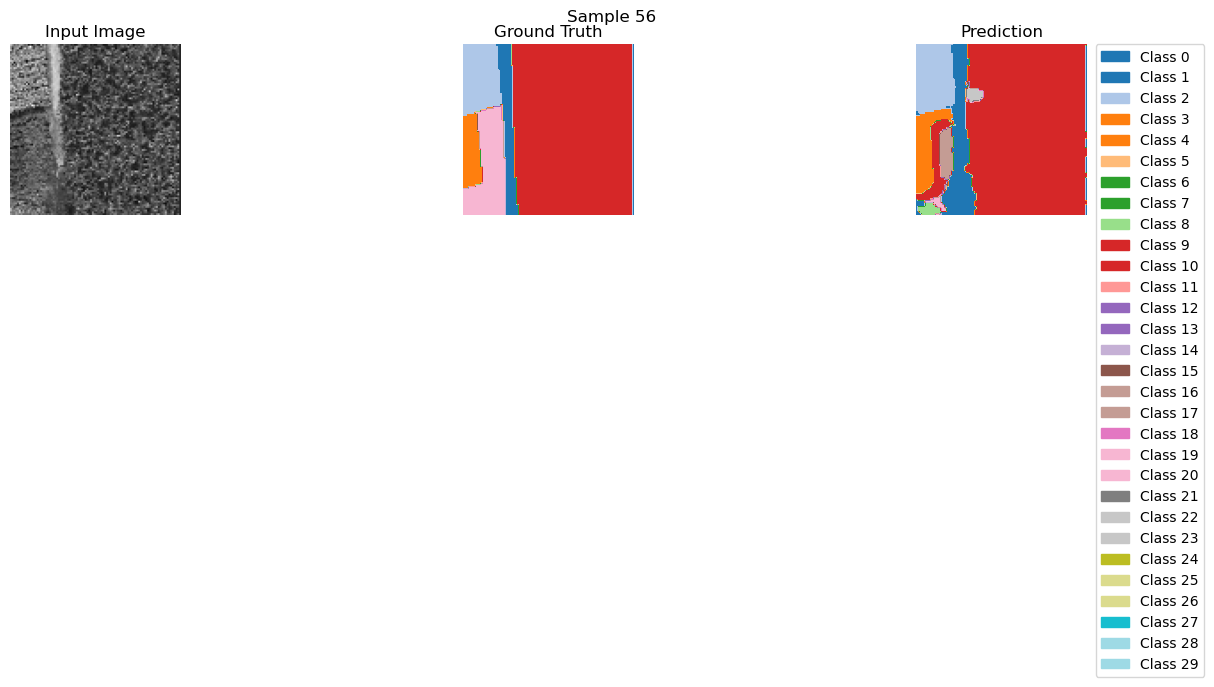

Visualizing sample #23 with Dice=0.1330


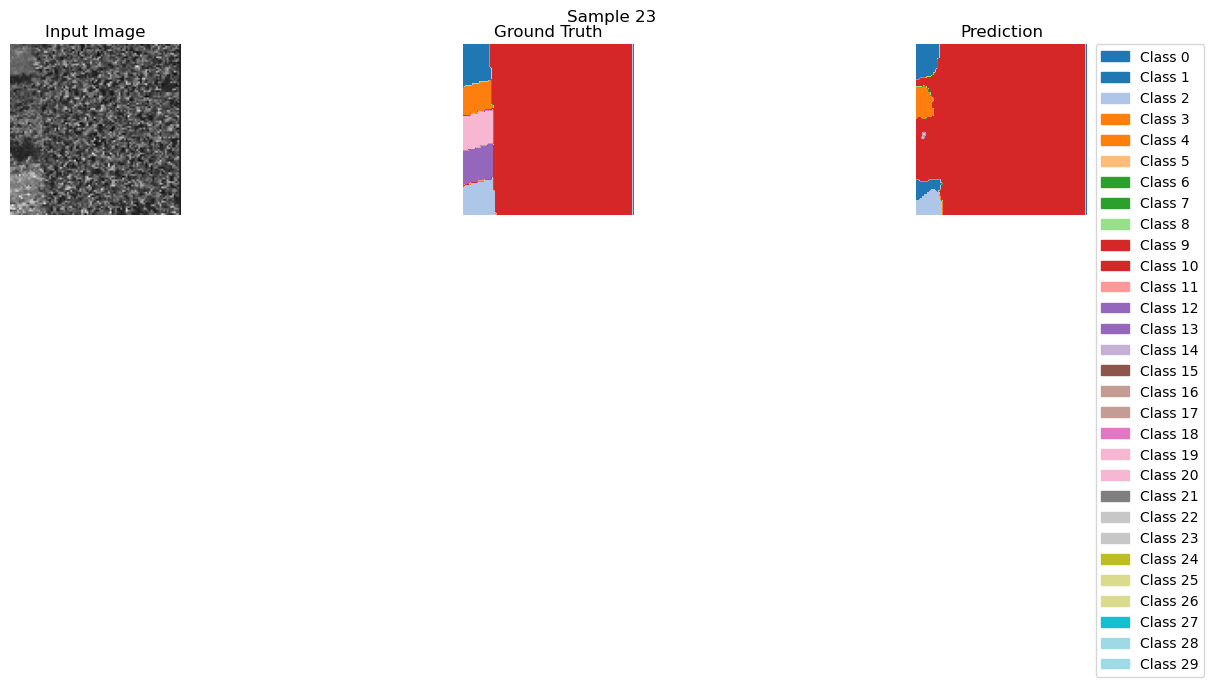

Visualizing sample #53 with Dice=0.1292


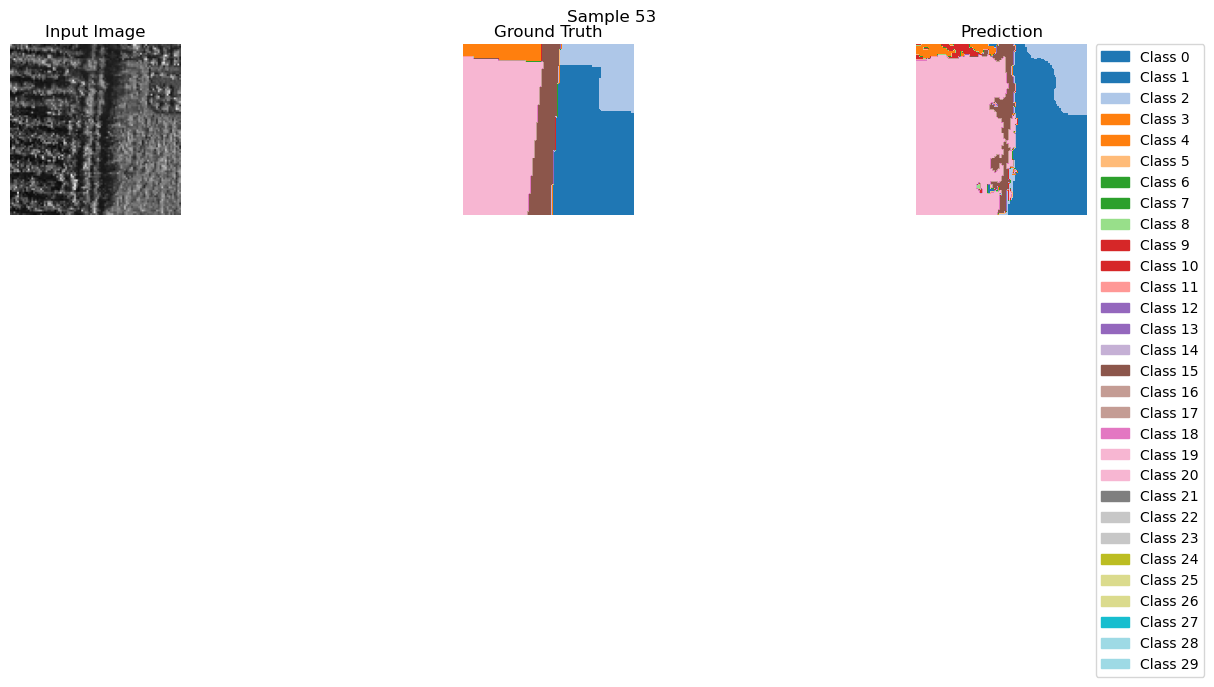

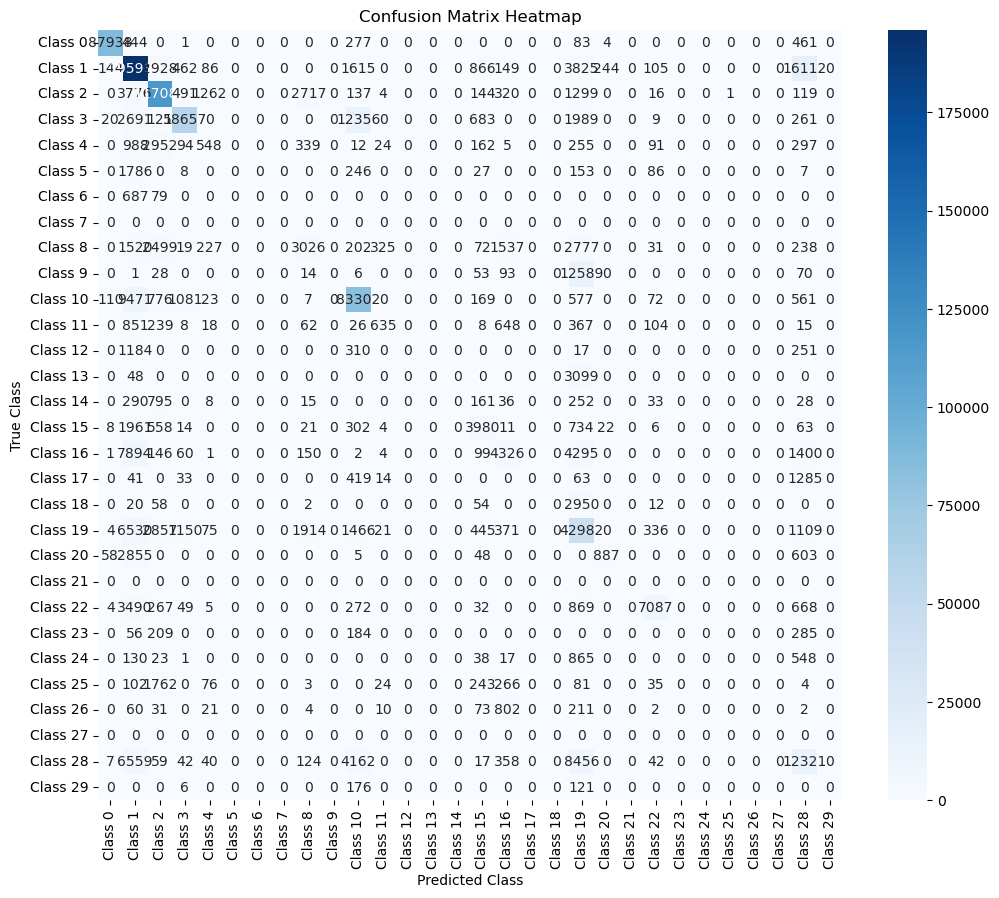

In [26]:
# Visualize top N test samples with highest Dice overlap per sample
n_visualize = 3
sample_dices = []

# Compute dice per sample on test set individually
import torch.nn.functional as F
model.eval()
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        images = batch['image'].to(device).unsqueeze(1)
        labels = batch['label'].to(device).long()
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        # Dice per sample (average over classes)
        preds_onehot = F.one_hot(preds, num_classes).permute(0,3,1,2).float()  # (B,C,H,W)
        labels_onehot = F.one_hot(labels, num_classes).permute(0,3,1,2).float()
        intersection = (preds_onehot * labels_onehot).sum(dim=(2,3))
        union = preds_onehot.sum(dim=(2,3)) + labels_onehot.sum(dim=(2,3))
        dice_per_class_sample = (2 * intersection / (union + 1e-6)).mean(dim=1)  # mean dice over classes per sample
        sample_dices.append((idx, dice_per_class_sample.item()))

# Sort by dice descending
sample_dices.sort(key=lambda x: x[1], reverse=True)

for rank, (idx, dice_val) in enumerate(sample_dices[:n_visualize]):
    batch = test_ds[idx]  # single sample
    image_np = batch['image'].numpy()
    gt_np = batch['label'].numpy()
    # Predict with model
    model.eval()
    with torch.no_grad():
        img_tensor = torch.from_numpy(image_np).unsqueeze(0).to(device).unsqueeze(1)
        out = model(img_tensor)
        pred = torch.argmax(out, dim=1).squeeze(0).cpu().numpy()
    print(f"Visualizing sample #{idx} with Dice={dice_val:.4f}")
    visualize_prediction(image_np, gt_np, pred, class_names, idx=idx)

# Plot confusion matrix heatmap
plot_confusion_heatmap(conf_matrix, class_names)


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_heatmap(conf_matrix, class_names):
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

plot_confusion_heatmap(conf_matrix, class_names)


NameError: name 'conf_matrix' is not defined

CURRICULUM LEARNING

In [13]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from pytorch3dunet.unet3d.model import UNet2D
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

# Dataset class
class HSI2DDataset(Dataset):
    def __init__(self, base_dir, split):
        self.image_dir = os.path.join(base_dir, split, 'rs')
        self.label_dir = os.path.join(base_dir, split, 'gt')
        self.samples = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.npy')]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        name = self.samples[idx]
        img = np.load(os.path.join(self.image_dir, name + '.npy')).astype(np.float32)
        if img.shape[0] != 200:
            img = np.transpose(img, (2, 0, 1))
        for c in range(img.shape[0]):
            mn, mx = img[c].min(), img[c].max()
            if mx > mn:
                img[c] = (img[c] - mn) / (mx - mn)
        img_tensor = torch.from_numpy(img)
        lbl = np.load(os.path.join(self.label_dir, name + '.npy')).astype(np.int64)
        lbl_tensor = torch.from_numpy(lbl)
        return {"image": img_tensor, "label": lbl_tensor, "name": name}

# Compute difficulty as inverse minimum pixel count per image
def compute_difficulty_pixel_counts(gt_dir, samples, min_pixels=100):
    difficulty_scores = {}
    for name in samples:
        gt_path = os.path.join(gt_dir, name + '.npy')
        gt = np.load(gt_path)
        unique_classes, counts = np.unique(gt, return_counts=True)
        present_pixel_counts = [c for c in counts if c >= min_pixels]
        if len(present_pixel_counts) == 0:
            difficulty = float('inf')
        else:
            difficulty = 1 / min(present_pixel_counts)
        difficulty_scores[name] = difficulty
    return difficulty_scores

# Curriculum training with best model saving
def train_curriculum_model(base_dir, train_split, val_split, difficulty_scores, curriculum_thresholds, num_epochs_stage=5, save_path='best_model.pt'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet2D(in_channels=200, out_channels=30, is3d=False).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scaler = GradScaler()

    all_samples = list(difficulty_scores.keys())
    best_loss = float('inf')

    for stage, max_diff in enumerate(curriculum_thresholds):
        print(f"\nStarting Stage {stage+1} with max difficulty threshold {max_diff:.6e}")

        selected_samples = [s for s in all_samples if difficulty_scores[s] <= max_diff]
        print(f"Selected {len(selected_samples)} samples for this stage.")

        if len(selected_samples) == 0:
            print("No samples selected for this threshold, skipping stage.")
            continue

        full_dataset = HSI2DDataset(base_dir, train_split)
        subset_indices = [full_dataset.samples.index(name) for name in selected_samples]
        subset_dataset = Subset(full_dataset, subset_indices)
        train_loader = DataLoader(subset_dataset, batch_size=2, shuffle=True, num_workers=4, pin_memory=True)

        for epoch in range(num_epochs_stage):
            model.train()
            running_loss = 0.0
            pbar = tqdm(train_loader, desc=f"Stage {stage+1} Epoch {epoch+1}")
            for batch in pbar:
                images = batch['image'].to(device)
                labels = batch['label'].to(device).long()

                optimizer.zero_grad()
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item() * images.size(0)
                pbar.set_postfix(loss=loss.item())

            avg_loss = running_loss / len(train_loader.dataset)
            print(f"Stage {stage+1} Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

            # Save best model if improved
            if avg_loss < best_loss:
                best_loss = avg_loss
                torch.save(model.state_dict(), save_path)
                print(f"Saved best model with loss {best_loss:.4f}")

    print("Curriculum training complete.")

# Usage:
base_dir = '/home/mrudul/mrudul/data_UAV_HSI'
train_split = 'Train/Training'
val_split = 'Train/Validation'

full_dataset = HSI2DDataset(base_dir, train_split)
difficulty_scores = compute_difficulty_pixel_counts(os.path.join(base_dir, train_split, 'gt'), full_dataset.samples, min_pixels=100)

all_difficulties = np.array(list(difficulty_scores.values()))
print(f"Difficulty stats: min={all_difficulties.min():.6e}, max={all_difficulties.max():.6e}")

curriculum_thresholds = np.logspace(np.log10(all_difficulties.min()), np.log10(all_difficulties.max()), num=5)
print("Curriculum thresholds:", curriculum_thresholds)

train_curriculum_model(base_dir, train_split, val_split, difficulty_scores, curriculum_thresholds.tolist(), num_epochs_stage=5, save_path='best_unet2d_hsi.pt')


Difficulty stats: min=1.085069e-04, max=9.708738e-03
Curriculum thresholds: [0.00010851 0.00033372 0.00102638 0.00315672 0.00970874]

Starting Stage 1 with max difficulty threshold 1.085069e-04
Selected 23 samples for this stage.


Stage 1 Epoch 1: 100%|██████████| 12/12 [00:01<00:00,  6.42it/s, loss=3.08]


Stage 1 Epoch 1 Average Loss: 3.2699
Saved best model with loss 3.2699


Stage 1 Epoch 2: 100%|██████████| 12/12 [00:01<00:00,  6.37it/s, loss=2.96]


Stage 1 Epoch 2 Average Loss: 3.0653
Saved best model with loss 3.0653


Stage 1 Epoch 3: 100%|██████████| 12/12 [00:01<00:00,  6.55it/s, loss=2.9] 


Stage 1 Epoch 3 Average Loss: 2.9809
Saved best model with loss 2.9809


Stage 1 Epoch 4: 100%|██████████| 12/12 [00:01<00:00,  6.55it/s, loss=2.97]


Stage 1 Epoch 4 Average Loss: 2.9228
Saved best model with loss 2.9228


Stage 1 Epoch 5: 100%|██████████| 12/12 [00:01<00:00,  6.60it/s, loss=2.81]


Stage 1 Epoch 5 Average Loss: 2.8786
Saved best model with loss 2.8786

Starting Stage 2 with max difficulty threshold 3.337212e-04
Selected 41 samples for this stage.


Stage 2 Epoch 1: 100%|██████████| 21/21 [00:03<00:00,  6.97it/s, loss=2.85]


Stage 2 Epoch 1 Average Loss: 2.9463


Stage 2 Epoch 2: 100%|██████████| 21/21 [00:03<00:00,  6.84it/s, loss=2.88]


Stage 2 Epoch 2 Average Loss: 2.8513
Saved best model with loss 2.8513


Stage 2 Epoch 3: 100%|██████████| 21/21 [00:03<00:00,  6.97it/s, loss=3.01]


Stage 2 Epoch 3 Average Loss: 2.7885
Saved best model with loss 2.7885


Stage 2 Epoch 4: 100%|██████████| 21/21 [00:03<00:00,  6.86it/s, loss=2.63]


Stage 2 Epoch 4 Average Loss: 2.7376
Saved best model with loss 2.7376


Stage 2 Epoch 5: 100%|██████████| 21/21 [00:03<00:00,  6.87it/s, loss=3]   


Stage 2 Epoch 5 Average Loss: 2.6998
Saved best model with loss 2.6998

Starting Stage 3 with max difficulty threshold 1.026385e-03
Selected 94 samples for this stage.


Stage 3 Epoch 1: 100%|██████████| 47/47 [00:06<00:00,  7.34it/s, loss=2.84]


Stage 3 Epoch 1 Average Loss: 2.7738


Stage 3 Epoch 2: 100%|██████████| 47/47 [00:06<00:00,  7.32it/s, loss=2.93]


Stage 3 Epoch 2 Average Loss: 2.7284


Stage 3 Epoch 3: 100%|██████████| 47/47 [00:06<00:00,  7.33it/s, loss=2.78]


Stage 3 Epoch 3 Average Loss: 2.7010


Stage 3 Epoch 4: 100%|██████████| 47/47 [00:06<00:00,  7.28it/s, loss=2.61]


Stage 3 Epoch 4 Average Loss: 2.6803
Saved best model with loss 2.6803


Stage 3 Epoch 5: 100%|██████████| 47/47 [00:06<00:00,  7.25it/s, loss=2.59]


Stage 3 Epoch 5 Average Loss: 2.6659
Saved best model with loss 2.6659

Starting Stage 4 with max difficulty threshold 3.156723e-03
Selected 201 samples for this stage.


Stage 4 Epoch 1: 100%|██████████| 101/101 [00:13<00:00,  7.42it/s, loss=2.68]


Stage 4 Epoch 1 Average Loss: 2.7642


Stage 4 Epoch 2: 100%|██████████| 101/101 [00:13<00:00,  7.40it/s, loss=2.99]


Stage 4 Epoch 2 Average Loss: 2.7434


Stage 4 Epoch 3: 100%|██████████| 101/101 [00:13<00:00,  7.34it/s, loss=2.49]


Stage 4 Epoch 3 Average Loss: 2.7239


Stage 4 Epoch 4: 100%|██████████| 101/101 [00:13<00:00,  7.37it/s, loss=2.5] 


Stage 4 Epoch 4 Average Loss: 2.7145


Stage 4 Epoch 5: 100%|██████████| 101/101 [00:13<00:00,  7.30it/s, loss=2.52]


Stage 4 Epoch 5 Average Loss: 2.7059

Starting Stage 5 with max difficulty threshold 9.708738e-03
Selected 312 samples for this stage.


Stage 5 Epoch 1: 100%|██████████| 156/156 [00:21<00:00,  7.36it/s, loss=2.96]


Stage 5 Epoch 1 Average Loss: 2.7239


Stage 5 Epoch 2: 100%|██████████| 156/156 [00:21<00:00,  7.34it/s, loss=2.71]


Stage 5 Epoch 2 Average Loss: 2.7092


Stage 5 Epoch 3: 100%|██████████| 156/156 [00:21<00:00,  7.32it/s, loss=2.69]


Stage 5 Epoch 3 Average Loss: 2.7007


Stage 5 Epoch 4: 100%|██████████| 156/156 [00:21<00:00,  7.31it/s, loss=2.55]


Stage 5 Epoch 4 Average Loss: 2.6915


Stage 5 Epoch 5: 100%|██████████| 156/156 [00:21<00:00,  7.27it/s, loss=2.64]

Stage 5 Epoch 5 Average Loss: 2.6754
Curriculum training complete.


In [14]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch3dunet.unet3d.model import UNet2D
from tqdm import tqdm
from torchmetrics import Dice, JaccardIndex

class HSI2DDataset(Dataset):
    def __init__(self, image_dir, gt_dir):
        self.image_dir = image_dir
        self.label_dir = gt_dir
        self.samples = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.npy')]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        name = self.samples[idx]
        img = np.load(os.path.join(self.image_dir, name + '.npy')).astype(np.float32)
        # If shape (H, W, D), convert to (D, H, W)
        if img.shape[0] != 200:
            img = np.transpose(img, (2, 0, 1))
        for c in range(img.shape[0]):
            mn, mx = img[c].min(), img[c].max()
            if mx > mn:
                img[c] = (img[c] - mn) / (mx - mn)
        img_tensor = torch.from_numpy(img)
        lbl = np.load(os.path.join(self.label_dir, name + '.npy')).astype(np.int64)
        lbl_tensor = torch.from_numpy(lbl)
        return {"image": img_tensor, "label": lbl_tensor}

# Paths
test_image_dir = '/home/mrudul/mrudul/data_UAV_HSI/Test/rs'
test_gt_dir = '/home/mrudul/mrudul/data_UAV_HSI/Test/gt'
test_ds = HSI2DDataset(test_image_dir, test_gt_dir)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

# Model and device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet2D(in_channels=200, out_channels=30, is3d=False).to(device)
model.load_state_dict(torch.load('best_unet2d_hsi.pt', map_location=device))
model.eval()

# Metrics setup for per-class Dice and IoU (no averaging)
num_classes = 30
dice_metric = Dice(num_classes=num_classes, average='none', ignore_index=None).to(device)
iou_metric = JaccardIndex(num_classes=num_classes, average='none', ignore_index=None).to(device)

dice_sums = torch.zeros(num_classes, device=device)
iou_sums = torch.zeros(num_classes, device=device)
num_samples = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Inference/Test'):
        images = batch['image'].to(device)    # (1, 200, H, W)
        gt = batch['label'].to(device)        # (1, H, W)
        outputs = model(images)                # (1, 30, H, W)
        preds = torch.argmax(outputs, dim=1)  # (1, H, W)

        dice = dice_metric(preds, gt)  # Per-class (30,)
        iou = iou_metric(preds, gt)    # Per-class (30,)

        dice_sums += dice
        iou_sums += iou
        num_samples += 1

# Average per-class metric over all samples
mean_dice_per_class = (dice_sums / num_samples).cpu().numpy()
mean_iou_per_class = (iou_sums / num_samples).cpu().numpy()

print("Per-class Dice and IoU scores:")
for cls_idx in range(num_classes):
    print(f"Class {cls_idx}: Dice = {mean_dice_per_class[cls_idx]:.4f}, IoU = {mean_iou_per_class[cls_idx]:.4f}")


Inference/Test: 100%|██████████| 87/87 [00:01<00:00, 60.88it/s]

Per-class Dice and IoU scores:
Class 0: Dice = nan, IoU = 0.1564
Class 1: Dice = nan, IoU = 0.2807
Class 2: Dice = nan, IoU = 0.0000
Class 3: Dice = nan, IoU = 0.0000
Class 4: Dice = nan, IoU = 0.0000
Class 5: Dice = nan, IoU = 0.0000
Class 6: Dice = nan, IoU = 0.0000
Class 7: Dice = nan, IoU = 0.0000
Class 8: Dice = nan, IoU = 0.0000
Class 9: Dice = nan, IoU = 0.0000
Class 10: Dice = nan, IoU = 0.0000
Class 11: Dice = nan, IoU = 0.0000
Class 12: Dice = nan, IoU = 0.0000
Class 13: Dice = nan, IoU = 0.0000
Class 14: Dice = nan, IoU = 0.0000
Class 15: Dice = nan, IoU = 0.0000
Class 16: Dice = nan, IoU = 0.0000
Class 17: Dice = nan, IoU = 0.0000
Class 18: Dice = nan, IoU = 0.0000
Class 19: Dice = nan, IoU = 0.0000
Class 20: Dice = nan, IoU = 0.0000
Class 21: Dice = nan, IoU = 0.0000
Class 22: Dice = nan, IoU = 0.0000
Class 23: Dice = nan, IoU = 0.0000
Class 24: Dice = nan, IoU = 0.0000
Class 25: Dice = nan, IoU = 0.0000
Class 26: Dice = nan, IoU = 0.0000
Class 27: Dice = nan, IoU = 0.0000